# Data

In [1]:
import os

import urllib.request
import pandas as pd
import numpy as np
import tmdbsimple as tmdb
from IPython.display import display, HTML, Image

### For img scraping
from lib.utility import tmdb_img_download,display_images,cosine_matrix

### For deep learning feature extraction
from lib.extractor import ImgExtractor

from IPython.display import display

from scipy import sparse
import pyspark
from pyspark.sql import SQLContext
from pyspark.mllib.recommendation import ALS,MatrixFactorizationModel, Rating
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
import multiprocessing
from multiprocessing import Process, Manager


### Rating data

In [2]:
"""movie rating data: Only run it one time""" 

ratingUrl = "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
urllib.request.urlretrieve(ratingUrl,"data/ml-latest-small.zip")
os.system("unzip -a -n data/ml-latest-small.zip -d data/")
os.listdir("data/")

['.DS_Store', 'ml-latest-small', 'ml-latest-small.zip', 'poster']

### Poster data

In [3]:
### Poster data
id = 505
tmdbPath = 'http://image.tmdb.org/t/p/w185/' # check https://developers.themoviedb.org/3/getting-started/image-languages

key_v3 = '10f40f0d5d794e4bacb266188128a896'

tmdb_connector = tmdb
tmdb_connector.API_KEY = key_v3

movieInfo = tmdb.Movies(id).info()
# print(movieInfo)
posterPath = movieInfo['poster_path']
fullPath = tmdbPath + posterPath
# print(fullPath)
# display_images(id=600,path_db=path_db)

In [5]:
fullPath

'http://image.tmdb.org/t/p/w185//fJBea43DpS6BhL9ZTBDoTNMiOG6.jpg'

In [6]:
# os.path.join(os.getcwd(),"data/poster/{}.jpg".format(id))
urllib.request.urlretrieve(fullPath, "data/poster/{}.jpg".format(id))

('data/poster/505.jpg', <http.client.HTTPMessage at 0x26a44329ac8>)

### Show data

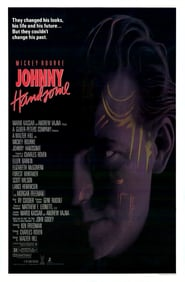

In [15]:
Image(fullPath)

# Part 1: Recommendation based on movie rating data
#### Tools: Spark, ALS model

In [16]:
rating_df = pd.read_csv('data/ml-latest-small/ratings.csv')
linkes_df = pd.read_csv('data/ml-latest-small/links.csv')

df_merged = pd.merge(rating_df,linkes_df,on=['movieId'])
df_merged.dropna(how="any",inplace=True)
df_merged[['tmdbId']] = df_merged[['tmdbId']].astype(int)

# df_merged['tmdbId'] = [int(x) for x in df_merged.tmdbId]
print(df_merged.head())
print(df_merged.shape)

   userId  movieId  rating   timestamp  imdbId  tmdbId
0       1        1     4.0   964982703  114709     862
1       5        1     4.0   847434962  114709     862
2       7        1     4.5  1106635946  114709     862
3      15        1     2.5  1510577970  114709     862
4      17        1     4.5  1305696483  114709     862
(100823, 6)


In [17]:
len(df_merged.tmdbId.unique())

9715

In [21]:
"""Generate Rating matrix""" 
df_rating = df_merged[['userId','tmdbId','rating']]
df_rating.head()

,userId,tmdbId,rating
0,1,862,4.0
1,5,862,4.0
2,7,862,4.5
3,15,862,2.5
4,17,862,4.5


In [22]:
"""Create SparkContext"""
### You can only have one sparkContext at the same tim
sc = pyspark.SparkContext.getOrCreate()

# sc = pyspark.SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

In [23]:
"""Create Spark dataframe"""
df_spark = sqlContext.createDataFrame(df_rating)
df_spark.printSchema()

root
 |-- userId: long (nullable = true)
 |-- tmdbId: long (nullable = true)
 |-- rating: double (nullable = true)



In [24]:
df_spark.head(5)

[Row(userId=1, tmdbId=862, rating=4.0),
 Row(userId=5, tmdbId=862, rating=4.0),
 Row(userId=7, tmdbId=862, rating=4.5),
 Row(userId=15, tmdbId=862, rating=2.5),
 Row(userId=17, tmdbId=862, rating=4.5)]

In [25]:
"""Train ALS model """
rank = 5
numIterations = 10
model = ALS.train(df_spark, rank, numIterations)

### ALS: One of Collabrative filtering 

#1 User features S

#2 bridge        V

#3 Product       D

In [26]:
"""Recommendation based on Users & Products"""
display('features for product one', model.productFeatures().first())
display('features for user one',model.userFeatures().first())

# For Product X, Find N Users to Sell To
productForUser = model.recommendUsers(242,10)
print("Top 10 moive recommendations for user 242: \n")
display(productForUser)

'features for product one'

(16,
 array('d', [-3.2081079483032227, 0.19084908068180084, 0.15934571623802185, 1.6843806505203247, 0.043916624039411545]))

'features for user one'

(8,
 array('d', [-0.6620160937309265, 0.4734207093715668, 0.31253349781036377, 1.1455702781677246, -0.3498074412345886]))

Top 10 moive recommendations for user 242: 



[Rating(user=461, product=242, rating=5.903162511457472),
 Rating(user=364, product=242, rating=5.826700627469933),
 Rating(user=96, product=242, rating=5.801786113970772),
 Rating(user=542, product=242, rating=5.716768900178263),
 Rating(user=224, product=242, rating=5.5521880715094),
 Rating(user=508, product=242, rating=5.407314548412224),
 Rating(user=203, product=242, rating=5.3455316713875645),
 Rating(user=327, product=242, rating=5.335737565486928),
 Rating(user=236, product=242, rating=5.326812439679407),
 Rating(user=360, product=242, rating=5.3154877298050796)]

In [10]:
# For User Y Find N Products to Promote
userForProduct = model.recommendProducts(196,10)
print("Top 10 users to recommend for product 196")
display(userForProduct)

Top 10 users to recommend for product 196


[Rating(user=196, product=15800, rating=12.754916420064292),
 Rating(user=196, product=14030, rating=9.152368806804875),
 Rating(user=196, product=5967, rating=8.696393995558559),
 Rating(user=196, product=40771, rating=8.528704929887095),
 Rating(user=196, product=14651, rating=8.429001042892924),
 Rating(user=196, product=16395, rating=8.421819810955078),
 Rating(user=196, product=15258, rating=8.368968709103065),
 Rating(user=196, product=31442, rating=8.342589054325748),
 Rating(user=196, product=1550, rating=8.29962525681073),
 Rating(user=196, product=10557, rating=8.229233313140565)]

In [14]:
# Predict ratings
ratingPredict= model.predict(196,242)
print("prediction of rate for User 196 --> movie 242")
display(ratingPredict)

productFeatures = model.productFeatures()
productFeatures.collect()

prediction of rate for User 196 --> movie 242


1.5527195259427011

[(16,
  array('d', [2.8203372955322266, 1.2555738687515259, 0.8734229803085327, 2.8536925315856934, 0.37378981709480286])),
 (24,
  array('d', [1.7017757892608643, 0.8276656270027161, 0.9186758399009705, 3.4258642196655273, -0.3518310487270355])),
 (64,
  array('d', [1.7176063060760498, 0.9110068678855896, 1.365815281867981, 3.283940553665161, 0.9018848538398743])),
 (80,
  array('d', [0.6985114812850952, 0.6230204105377197, 3.7003700733184814, 2.655076026916504, 0.9587792754173279])),
 (88,
  array('d', [-0.04278716817498207, 0.9330753087997437, 0.5964272022247314, 2.792462110519409, -0.9645797610282898])),
 (96,
  array('d', [0.9664044380187988, 0.7472236156463623, -0.025444142520427704, 2.1877708435058594, -1.534083366394043])),
 (104,
  array('d', [1.613348126411438, 0.7475579977035522, 1.149898886680603, 3.153261661529541, -0.7356531620025635])),
 (112,
  array('d', [1.3562568426132202, 0.8183099627494812, 0.3232887089252472, 1.9638174772262573, -0.3866952061653137])),
 (120,
  ar

### Evaluation

In [14]:
"""Get Mean Square Error"""
# True:4.6 pred:5, cost: 0.4**2

# Background: ALS: 1 sparse matrix, 2 only a few rating 3 based on few rating --> get all rating
# Sparse matrix: row:user, column: movie id, eg: 600 user, 100,00 movie rating, 4000 rating (ground truth), 6))*100,000   
# Train process: 1. calculate all rating. 

# Interview: Decomposed based, decompose to user feature, project feature & transformation matrix

'Get Mean Square Error'

# Recommendation based on Posters (CNN)

In [27]:
"""Download poster data for tmdb movies"""

tmdbIds = df_spark.select('tmdbId').distinct().collect()
tmdbIdsPool = set([x.asDict()['tmdbId'] for x in tmdbIds])

In [35]:
len(tmdbIdsPool)

9715

In [58]:
def helper(id):
    tmdbPath = 'https://image.tmdb.org/t/p/w185' # check https://developers.themoviedb.org/3/getting-started/image-languages

    movieInfo = tmdb.Movies(id).info()
    # print(movieInfo)
    posterPath = movieInfo['poster_path']
    fullPath = tmdbPath + posterPath
    #print(fullPath)
    urllib.request.urlretrieve(fullPath, "data/poster/{}.jpg".format(id))
    print(id,"downloaded successfully")

In [59]:
notAvailable = []
for id in list(tmdbIdsPool)[:10]:
    try:
        tmpPath = helper(id)
    except:
        notAvailable.append(id)

https://image.tmdb.org/t/p/w185/gZCJZOn4l0Zj5hAxsMbxoS6CL0u.jpg
2 downloaded successfully
~~~
https://image.tmdb.org/t/p/w185/eQs5hh9rxrk1m4xHsIz1w11Ngqb.jpg
5 downloaded successfully
~~~
https://image.tmdb.org/t/p/w185/lNXmgUrP6h1nD53gkFh4WDzT6RZ.jpg
6 downloaded successfully
~~~
https://image.tmdb.org/t/p/w185/btTdmkgIvOi0FFip1sPuZI2oQG6.jpg
11 downloaded successfully
~~~
https://image.tmdb.org/t/p/w185/syPWyeeqzTQIxjIUaIFI7d0TyEY.jpg
12 downloaded successfully
~~~
https://image.tmdb.org/t/p/w185/yE5d3BUhE8hCnkMUJOo1QDoOGNz.jpg
13 downloaded successfully
~~~
https://image.tmdb.org/t/p/w185/lZj7LHX6kUXjoUuZXx4ZFysqx7S.jpg
65550 downloaded successfully
~~~
https://image.tmdb.org/t/p/w185/or1MP8BZIAjqWYxPdPX724ydKar.jpg
14 downloaded successfully
~~~
https://image.tmdb.org/t/p/w185/sav0jxhqiH0bPr2vZFU0Kjt2nZL.jpg
15 downloaded successfully
~~~
https://image.tmdb.org/t/p/w185/7xizDTz4Yj4IYm2ud4f6EfEXe5H.jpg
16 downloaded successfully
~~~


In [57]:
#urllib.request.urlretrieve('https://image.tmdb.org/t/p/w185/gZCJZOn4l0Zj5hAxsMbxoS6CL0u.jpg', "data/poster/{}.jpg".format(2))

('data/poster/2.jpg', <http.client.HTTPMessage at 0x1f64501c208>)

In [19]:
"""Scrape movie poster from restful API with multiprocess"""
with ThreadPoolExecutor(max_workers=10) as ex:
    ex.map(lambda x: helper(x),tmdbIdsPool)

14 downloaded successfully
12 downloaded successfully
5 downloaded successfully
16 downloaded successfully
2 downloaded successfully
15 downloaded successfully
13 downloaded successfully
11 downloaded successfully
6 downloaded successfully
65550 downloaded successfully
18 downloaded successfully
19 downloaded successfully
24 downloaded successfully
20 downloaded successfully
25 downloaded successfully
21 downloaded successfully
33 downloaded successfully
28 downloaded successfully
3522  downloaded successfully
downloaded successfully
38 downloaded successfully
196649 downloaded successfully
294963 downloaded successfully
58 downloaded successfully
32823 downloaded successfully
55 downloaded successfully
65595 downloaded successfully
63 downloaded successfully
62 downloaded successfully
59 downloaded successfully
64 downloaded successfully
65 downloaded successfully
32836 downloaded successfully
67 downloaded successfully
66 downloaded successfully
69 downloaded successfully
68 download

16771 downloaded successfully
16780 downloaded successfully
49538 downloaded successfully
278927 downloaded successfully
16784 downloaded successfully
16806 downloaded successfully
49565 downloaded successfully
16820 downloaded successfully
278990 downloaded successfully
16858 downloaded successfully
16859 downloaded successfully
16857 downloaded successfully
16804 downloaded successfully
16866 downloaded successfully
49636 downloaded successfully
16869 downloaded successfully
16885 downloaded successfully
16871 downloaded successfully
16876 downloaded successfully
74998 downloaded successfully
16889 downloaded successfully
16888 downloaded successfully
115199 downloaded successfully
16905 downloaded successfully
49680 downloaded successfully
16933 downloaded successfully
49689 downloaded successfully
16938 downloaded successfully
16934 downloaded successfully
49721 downloaded successfully
16939 downloaded successfully
16909 downloaded successfully
49730 downloaded successfully
16958 d

In [17]:
posterIds = os.listdir('data/poster/')

extractor = ImgExtractor(model="VGG16")

In [18]:
len(posterIds)

400

In [19]:
features = extractor.get_features("data/poster/505.jpg")

load Image locally


In [20]:
features.shape

(1, 1000)

### Compare similarity
#### Cosine similarity

In [31]:
# you like one poster, find the most similar poster

In [4]:
"""Define function to extract features from folder"""
def helper(id,posterPath):
    pwd = os.getcwd()
    path = os.path.join(pwd,posterPath,str(id))
    filename = os.listdir(path)[0]
    imgPath = os.path.join(path,filename)
    feature = extractor.get_features(imgPath)
    print("Load Image {} success".format(id))
    return feature

In [ ]:
dicFeatures = {}
for id in posterIds:
    dicFeatures[id] = helper(id,posterPath="data/poster")

## Recommend based on features of Poster

#### 1extract features for all posters
#### 2compare cosine similarity


In [7]:
!pip install gym
